1 - Import needed libaries and functions 

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import torch as th

2 - Import training/testing data and labels

In [2]:
# Import training data (2400 observatios, each with dimension 12288)
X_train = pd.read_csv("/Users/akv020/Projects/ML classification of dust/Dataverse/Train_and_test_data/Train_data.csv",header=None)
# Import testing data (600 observatios, each with dimension 12288)
X_test = pd.read_csv("/Users/akv020/Projects/ML classification of dust/Dataverse/Train_and_test_data/Test_data.csv",header=None)

# Import 2400 training labels and 600 testing labels
Y_train = pd.read_csv("/Users/akv020/Projects/ML classification of dust/Dataverse/Train_and_test_data/Train_labels.csv",header=None)
Y_test = pd.read_csv("/Users/akv020/Projects/ML classification of dust/Dataverse/Train_and_test_data/Test_labels.csv",header=None)

3 - Reshape training and testing data to dimension (3x4096) to account for the 3 antenna measurements 

In [4]:
print('Imported data size: ')
print(X_train.shape)
print(X_test.shape)

sz = X_train.shape
L = int(sz[1]/3)
X_train = X_train.to_numpy().reshape(2400,L, 3)
X_test = X_test.to_numpy().reshape(600,L, 3)

print('Reshaped data size: ')
print(X_train.shape)
print(X_test.shape)

Imported data size: 
(2400, 12288)
(600, 12288)
Reshaped data size: 
(2400, 4096, 3)
(600, 4096, 3)


5 - Plot an example of a dust impact signal

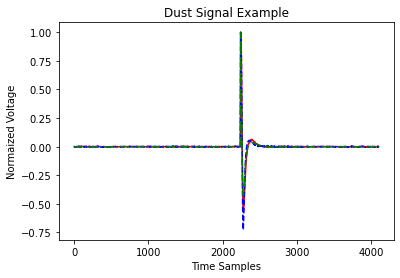

In [10]:
antenna1 = X_train[1001,:,0]
antenna2 = X_train[1001,:,1]
antenna3 = X_train[1001,:,2]
plt.plot(antenna1,'r-')
plt.plot(antenna2,'b--')
plt.plot(antenna3,'g-.')
plt.title('Dust Signal Example')
plt.xlabel('Time Samples')
plt.ylabel('Normaized Voltage')
plt.show()

7 - Define the CNN arcitecture (suggested by Wang et al. (2017)) and plot the CNN arcitecture in a diagram 

In [11]:
# Define the CNN arcitecture
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,strides=1, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5,strides=1, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=128, kernel_size=3,strides=1, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train.shape[1:])

# Plot a diagram of the model arcitecture 
keras.utils.plot_model(model, show_shapes=True)

# Numer of times to run through the training data
epochs = 225
# Number of samples to run through before updating the network parameters 
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "run_GitHub.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=100, min_lr=0.000001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=300, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

8 - Test the trained model using the testing data and print results 

In [15]:
model = keras.models.load_model("run_GitHub.h5")
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

 4/19 [=====>........................] - ETA: 0s - loss: 0.0761 - sparse_categorical_accuracy: 0.9688

2022-07-07 17:02:38.146656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 21ms/step - loss: 0.1405 - sparse_categorical_accuracy: 0.9567
Test accuracy 0.9566667079925537
Test loss 0.14052154123783112


9 - Plot the validation accuracy at each epoch

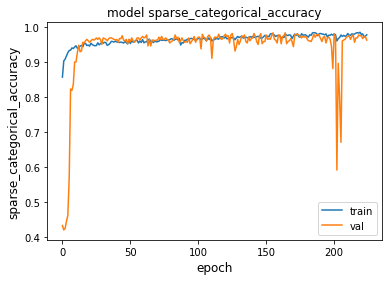

In [16]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

10 - Print number of correctly/erroneously classified observations and print confusion matrix  

In [17]:
Y_pred = model.predict(X_test)
Y_pred = [0 if y[0]>=0.5 else 1 for y in Y_pred]

total = 0
correct = 0
wrong = 0
for i in range(len(Y_pred)):
  total=total+1
  if(Y_test.at[i,0] == Y_pred[i]):
    correct=correct+1
  else:
    wrong=wrong+1

print("Total " + str(total))
print("Correct " + str(correct))
print("Wrong " + str(wrong))

from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred)

2022-07-07 17:02:51.201492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Total 600
Correct 574
Wrong 26


array([[344,  18],
       [  8, 230]])

11 - Print model summary and save the trained network

In [18]:
model.summary()
model.save("model_run_GitHub")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096, 3)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4096, 128)         3200      
                                                                 
 batch_normalization (BatchN  (None, 4096, 128)        512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4096, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4096, 256)         164096    
                                                                 
 batch_normalization_1 (Batc  (None, 4096, 256)        1024      
 hNormalization)                                             